In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.4.0


In [2]:
# load daily weather data since 1970
# PRCP: precipitation in inches
# TMAX, TMIN: maximum and minimum temperature in Farenheit 
weather = pd.read_csv('3167005.csv', parse_dates=['DATE'])
print(weather.shape)
weather.head()

(19328, 10)


,STATION,NAME,DATE,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,TOBS
0,USW00023271,"SACRAMENTO 5 ESE, CA US",1970-01-01,0.0,NaN,NaN,NaN,56.0,31.0,NaN
1,USW00023271,"SACRAMENTO 5 ESE, CA US",1970-01-02,0.0,NaN,NaN,NaN,54.0,32.0,NaN
2,USW00023271,"SACRAMENTO 5 ESE, CA US",1970-01-03,0.0,NaN,NaN,NaN,56.0,35.0,NaN
3,USW00023271,"SACRAMENTO 5 ESE, CA US",1970-01-04,0.0,NaN,NaN,NaN,50.0,30.0,NaN
4,USW00023271,"SACRAMENTO 5 ESE, CA US",1970-01-05,0.0,NaN,NaN,NaN,52.0,33.0,NaN


In [3]:
weather.tail()

,STATION,NAME,DATE,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,TOBS
19323,USW00023271,"SACRAMENTO 5 ESE, CA US",2022-11-27,0.00,0.0,NaN,NaN,67.0,39.0,NaN
19324,USW00023271,"SACRAMENTO 5 ESE, CA US",2022-11-28,0.00,0.0,NaN,NaN,64.0,38.0,NaN
19325,USW00023271,"SACRAMENTO 5 ESE, CA US",2022-11-29,0.00,0.0,NaN,NaN,61.0,37.0,NaN
19326,USW00023271,"SACRAMENTO 5 ESE, CA US",2022-11-30,0.00,0.0,NaN,NaN,61.0,34.0,NaN
19327,USW00023271,"SACRAMENTO 5 ESE, CA US",2022-12-01,0.58,0.0,NaN,NaN,50.0,39.0,NaN


In [4]:
weather.describe()

,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,TOBS
count,19326.000000,10296.000000,2608.0,1553.000000,19323.000000,19324.000000,0.0
mean,0.051827,0.000068,0.0,64.408242,75.737929,51.364210,NaN
std,0.198795,0.006899,0.0,11.990578,15.662377,8.885684,NaN
min,0.000000,0.000000,0.0,36.000000,32.000000,18.000000,NaN
25%,0.000000,0.000000,0.0,54.000000,63.000000,45.000000,NaN
50%,0.000000,0.000000,0.0,65.000000,76.000000,52.000000,NaN
75%,0.000000,0.000000,0.0,74.000000,89.000000,58.000000,NaN
max,5.440000,0.700000,0.0,94.000000,116.000000,84.000000,NaN


In [5]:
weather.isna().sum()

STATION        0
NAME           0
DATE           0
PRCP           2
SNOW        9032
SNWD       16720
TAVG       17775
TMAX           5
TMIN           4
TOBS       19328
dtype: int64

In [6]:
# year column for use in grouping
weather['YEAR'] = weather.DATE.dt.year
# create column indicating if it rained that day
weather['RAINED'] = (weather['PRCP']>0)
# drop columns with all nan or all zero
weather.drop(['SNOW', 'SNWD', 'TOBS'], axis=1, inplace=True)
# fill na with zero
weather.fillna(0, inplace=True)

In [7]:
weather.head()

,STATION,NAME,DATE,PRCP,TAVG,TMAX,TMIN,YEAR,RAINED
0,USW00023271,"SACRAMENTO 5 ESE, CA US",1970-01-01,0.0,0.0,56.0,31.0,1970,False
1,USW00023271,"SACRAMENTO 5 ESE, CA US",1970-01-02,0.0,0.0,54.0,32.0,1970,False
2,USW00023271,"SACRAMENTO 5 ESE, CA US",1970-01-03,0.0,0.0,56.0,35.0,1970,False
3,USW00023271,"SACRAMENTO 5 ESE, CA US",1970-01-04,0.0,0.0,50.0,30.0,1970,False
4,USW00023271,"SACRAMENTO 5 ESE, CA US",1970-01-05,0.0,0.0,52.0,33.0,1970,False


In [8]:
weather[weather['PRCP']>4]

,STATION,NAME,DATE,PRCP,TAVG,TMAX,TMIN,YEAR,RAINED
18924,USW00023271,"SACRAMENTO 5 ESE, CA US",2021-10-24,5.44,0.0,60.0,55.0,2021,True


Text(0, 0.5, 'Amount Precipitation (inches)')

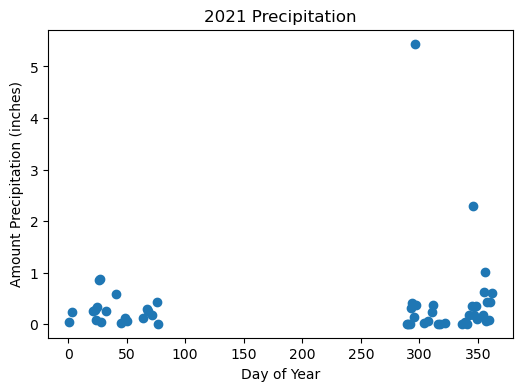

In [9]:
# 5.44 precipitation outlier... actually real, cross-referenced new stories of that storm
# isolate 2021 weather subset, days with rain
w21 = weather[weather['YEAR']==2021]
rainamts = w21[w21['PRCP']>0]['PRCP']

plt.figure(figsize=(6,4))
plt.plot(rainamts.index - min(w21.index), rainamts, 'o')
plt.title('2021 Precipitation')
plt.xlabel('Day of Year')
plt.ylabel('Amount Precipitation (inches)')

In [10]:
precip = pd.DataFrame()
# total inches of rain/year
precip['TOT_PRCP'] = weather.groupby('YEAR')['PRCP'].sum()
# number of rain days/year
precip['PRCP_DAYS'] = (weather.groupby('YEAR')['RAINED']).sum()
# average precipitation on rain days
precip['PRCP_AVG'] = precip['TOT_PRCP'] / precip['PRCP_DAYS']
# drop year 2022 since data incomplete for that year
precip.drop(2022, axis=0, inplace=True)
precip.head()

,TOT_PRCP,PRCP_DAYS,PRCP_AVG
YEAR,,,
1970,22.83,69,0.330870
1971,11.29,58,0.194655
1972,14.37,64,0.224531
1973,28.86,82,0.351951
1974,17.50,58,0.301724


In [11]:
# create x and y data
xdata = np.array(precip.index - min(precip.index))
ydata = np.array(precip['TOT_PRCP'])
print(xdata[:10], ydata[:10])

[0 1 2 3 4 5 6 7 8 9] [22.83 11.29 14.37 28.86 17.5  15.34  6.67 11.39 23.58 22.33]


Text(0, 0.5, '# Precipitation Days')

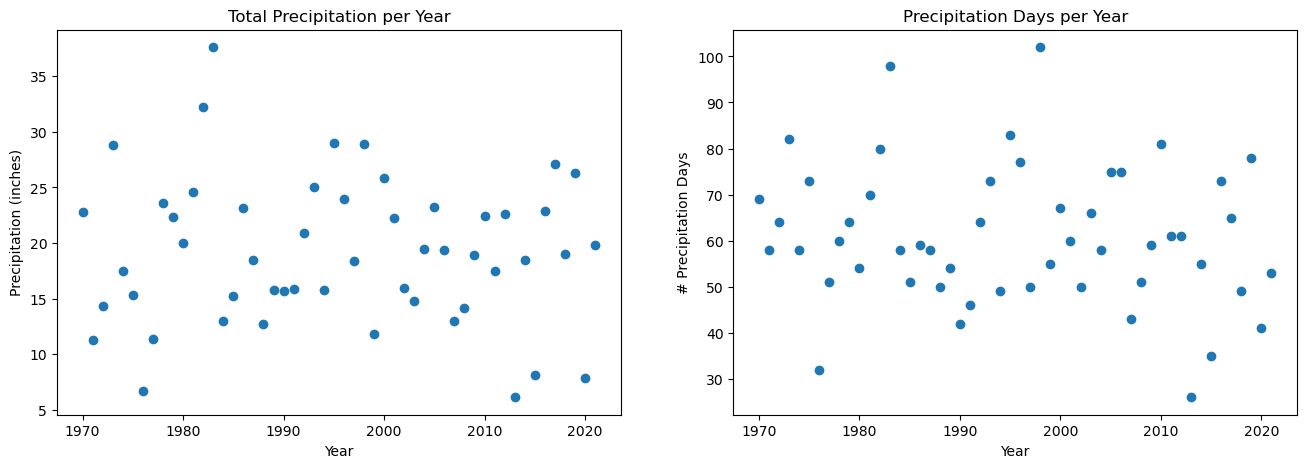

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(16,5))

axs[0].plot(precip['TOT_PRCP'], 'o')
axs[0].set_title('Total Precipitation per Year')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Precipitation (inches)')

axs[1].plot(precip['PRCP_DAYS'], 'o')
axs[1].set_title('Precipitation Days per Year')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('# Precipitation Days')

19.177115384615384 6.565205173246111


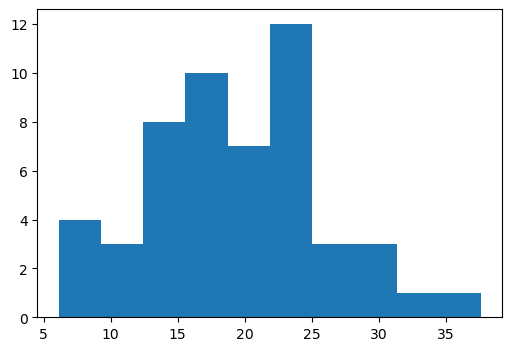

In [13]:
plt.figure(figsize=(6,4))
plt.hist(precip['TOT_PRCP'])
print(precip['TOT_PRCP'].mean(), precip['TOT_PRCP'].std())

In [14]:
# does it rain less thsn it used to?
# define model
with pm.Model() as rain_model:
    # priors for unknown parameters
    intercept = pm.Uniform('intercept', lower=min(xdata), upper=max(xdata))
    slope = pm.Uniform('slope', lower=-5, upper=5)
    sigma = pm.HalfNormal('sigma', sigma=10)
    
    # estimated output value given by regression and x data
    y_est = slope * xdata + intercept
    
    # connect estimated output with observed data
    # observed should be normally distributed around estimated y
    y = pm.Normal('y', mu=y_est, sigma=sigma, observed=ydata)
    

In [15]:
# draw samples from model
with rain_model:
    trace = pm.sample(draws=1000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, sigma]


Sampling 4 chains for 5_000 tune and 1_000 draw iterations (20_000 + 4_000 draws total) took 23 seconds.


array([[<AxesSubplot:title={'center':'intercept'}>,
        <AxesSubplot:title={'center':'intercept'}>],
       [<AxesSubplot:title={'center':'slope'}>,
        <AxesSubplot:title={'center':'slope'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

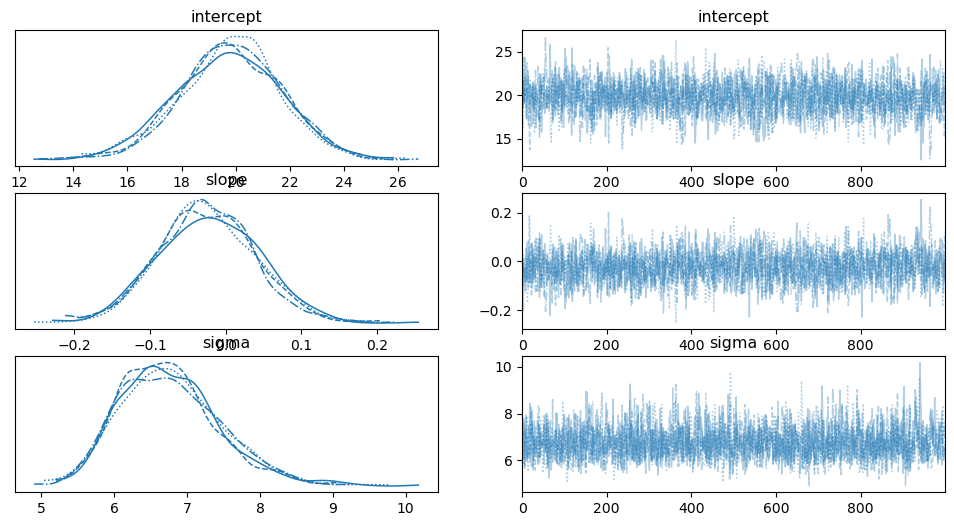

In [16]:
az.plot_trace(trace)

In [17]:
# summary of posterior distributions
summ = az.summary(trace, round_to=2)
summ

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,19.78,1.89,16.14,23.22,0.05,0.03,1520.14,1587.81,1.0
slope,-0.02,0.06,-0.14,0.10,0.00,0.00,1596.61,1161.50,1.0
sigma,6.76,0.69,5.52,8.03,0.02,0.01,1891.18,2224.07,1.0


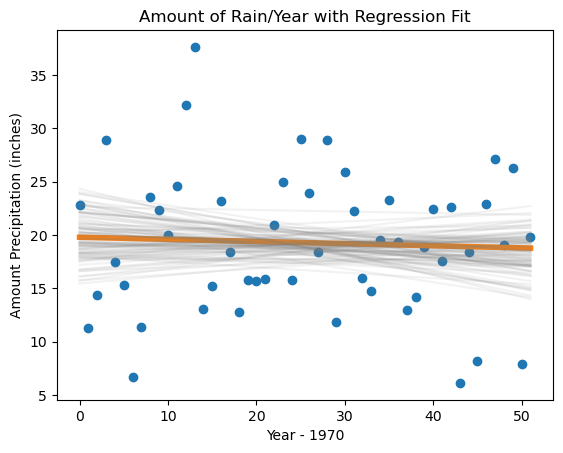

In [18]:
# plot data and fit line
plt.plot(xdata, ydata,'o')
plt.plot(xdata, summ.loc['slope', 'mean']*xdata + summ.loc['intercept', 'mean'], lw=4)
plt.title('Amount of Rain/Year with Regression Fit')
plt.xlabel('Year - 1970')
plt.ylabel('Amount Precipitation (inches)')

# plot alternate fits
slopes = trace.posterior['slope'].values.flatten()
intercepts = trace.posterior['intercept'].values.flatten()
sigmas = trace.posterior['sigma'].values.flatten()

idxs = np.random.choice(len(slopes), 100)
pred2022 = np.zeros(len(idxs))
for i, idx in enumerate(idxs):
    plt.plot(xdata, slopes[idx]*xdata + intercepts[idx], alpha=0.1, color='gray')
    
    # get estimate for 2022 (2022 - 1970 = 52) rain amount
    epsilon = np.random.normal(loc=0, scale=sigmas[idx])
    pred2022[i] = slopes[idx]*52 + intercepts[idx] + epsilon

In [19]:
# seems likely that there's less rain now, but data is noisy
# around 2/3 slopes negative
len(slopes[slopes<0])/len(slopes)

0.6475

(array([  1.,   4.,  11.,  21.,  46.,  81., 172., 252., 352., 435., 519.,
        481., 465., 394., 295., 195., 127.,  76.,  37.,  20.,   7.,   6.,
          1.,   1.,   1.]),
 array([-0.25339739, -0.23306909, -0.21274079, -0.1924125 , -0.1720842 ,
        -0.1517559 , -0.1314276 , -0.1110993 , -0.090771  , -0.0704427 ,
        -0.0501144 , -0.0297861 , -0.0094578 ,  0.0108705 ,  0.0311988 ,
         0.0515271 ,  0.07185539,  0.09218369,  0.11251199,  0.13284029,
         0.15316859,  0.17349689,  0.19382519,  0.21415349,  0.23448179,
         0.25481009]),
 <BarContainer object of 25 artists>)

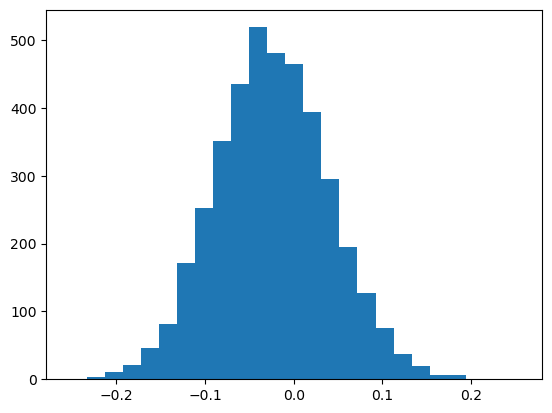

In [20]:
# slope samples
plt.hist(slopes, bins=25)

In [21]:
# estimated amount of rain for 2022
p5, p50, p95 = np.percentile(pred2022, q=[5, 50, 95])
print(f'5th percentile, median, 95th percentile: {p5:.2f}, {p50:.2f}, {p95:.2f} inches')

5th percentile, median, 95th percentile: 7.37, 18.94, 29.63 inches


Text(0.5, 1.0, 'Precipitation Estimates for 2022')

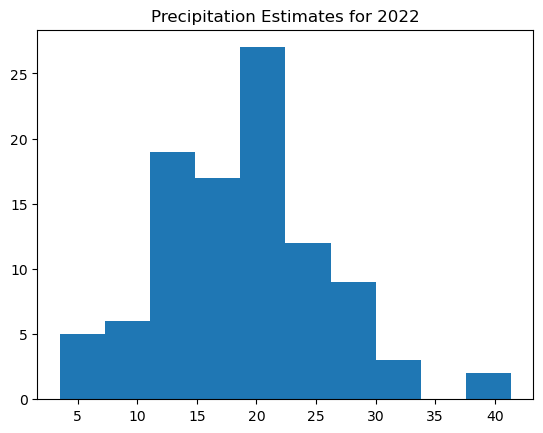

In [22]:
# lots of uncertainty shown by wide range
# actual rainfall in 2022 ~12.5 inches
plt.hist(pred2022)
plt.title('Precipitation Estimates for 2022')